**How do student’s number of school absences and failures affect the final grade?**

Portugal’s education is at the tail end of Europe’s educational level due to student failure and dropout rates (Cortez and Silvia, 2008). 
In 2006 Portugal's early school dropout rate was 40% for 18-24 year olds while the EU average was 15% (Cortez and Silvia, 2008). 
Particularly in Math core classes, which are built upon in later courses, failure rates were high (Cortez and Silvia, 2008). 
Using Business Intelligence (BI) and Data Mining (DM) methods to analyze trends could inform decision making around academic infrastructural support and corrective measures (Cortez and Silvia, 2008).

The data set that is going to be used is called Student Performance Data Set and  is provided by the University of Minho. It records 33 attributes (binary, nominal and numeric) such as gender, age, parents’ educational levels and occupations, the time students spend traveling to school, and personal time, among other factors that may affect students’ grades (Cortez and Silvia, 2008). 

Our data analysis will use travel, study, and free time, number of school absences, and overall health of student’s to determine their final Math grade(G3). Although the earlier grades G1 and G2 are helpful in predicting the final grade G3 our classification model will be explored without taking into consideration those factors. 


In [30]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.plot.width = 10, repr.plot.height = 10) 

**Methods**

Firstly, data frame is loaded from the original web source:

In [31]:
# Read the zip file from url and unzip so it can be loaded into a dataframe
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip"
zip_file <- tempfile(fileext = ".zip")
download.file(url, zip_file, mode = "wb")
student_data <- read_delim(unz(description = zip_file, filename = "student-mat.csv"), delim = ";")

Parsed with column specification:
cols(
  .default = col_character(),
  age = col_double(),
  Medu = col_double(),
  Fedu = col_double(),
  traveltime = col_double(),
  studytime = col_double(),
  failures = col_double(),
  famrel = col_double(),
  freetime = col_double(),
  goout = col_double(),
  Dalc = col_double(),
  Walc = col_double(),
  health = col_double(),
  absences = col_double(),
  G1 = col_double(),
  G2 = col_double(),
  G3 = col_double()
)

See spec(...) for full column specifications.



Due to the fact that the final grades in the data set are distributed from 0 to 20, they are grouped according to Portuguese universities’ 5-level grade classification for easier classification. Grades 0-9 are a ‘fail’, 10-11 are ‘sufficient’, 12-13 are ‘satisfactory’, 14-15 are ‘good’, and 16-20 are ‘excellent’. 

In [32]:
# Grouped the Final Grade into intervals for easier labelling down the line
# Grades 0-5 is 1, 6-10 is 2, 11-15 is 3 and 16-20 is 4

student_data_group <- student_data %>%
    mutate(label = cut(G3, c(0, 9, 11, 13, 15, 20), 
                       #labels = c("fail", "sufficient", "satisfactory", "good", "excellent"), 
                       labels = c(1, 2, 3, 4, 5),
                       left = FALSE)) %>%
    group_by(label = as.factor(label)) %>%
    filter(!is.na(label))

head(student_data_group)

school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,⋯,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
GP,F,18,U,GT3,A,4,4,at_home,teacher,⋯,3,4,1,1,3,6,5,6,6,1
GP,F,17,U,GT3,T,1,1,at_home,other,⋯,3,3,1,1,3,4,5,5,6,1
GP,F,15,U,LE3,T,1,1,at_home,other,⋯,3,2,2,3,3,10,7,8,10,2
GP,F,15,U,GT3,T,4,2,health,services,⋯,2,2,1,1,5,2,15,14,15,4
GP,F,16,U,GT3,T,3,3,other,other,⋯,3,2,1,2,5,4,6,10,10,2
GP,M,16,U,LE3,T,4,3,services,other,⋯,4,2,1,2,5,10,15,15,15,4


Columns with binary data are removed as we were informed that initially they would not make suitable factors in KNN classification.


In [33]:
student_data_group_no_bin <- student_data_group %>%
    select(Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3, label)

head(student_data_group_no_bin)

Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
4,4,2,2,0,4,3,4,1,1,3,6,5,6,6,1
1,1,1,2,0,5,3,3,1,1,3,4,5,5,6,1
1,1,1,2,3,4,3,2,2,3,3,10,7,8,10,2
4,2,1,3,0,3,2,2,1,1,5,2,15,14,15,4
3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,2
4,3,1,2,0,5,4,2,1,2,5,10,15,15,15,4


We split our data set into 75% training and 25% testing data as our data set is small (n = 268).

In [34]:
# Split the data into training and testing set
#student_data_split <- initial_split(student_data_cleaned_binary, prop = 0.75, strata = label)
set.seed(2021)
student_data_split <- initial_split(student_data_group_no_bin, prop = 0.75, strata = label)
student_train <- training(student_data_split)
student_test <- testing(student_data_split)


Preliminary data analysis to look at where the largest counts or average lies for certain factors.

In [35]:
# Exploratory Data Analysis
# Distribution of mother's education level
student_train_meduc <- group_by(student_train, Medu) %>%
    summarize(n = n())

# Distribution of father's education level
student_train_feduc <- group_by(student_train, Fedu) %>%
    summarize(n = n())

# Counts number of student failures
student_train_failure <- group_by(student_train, failures) %>%
    summarize(n=n())

# Counts number of student absences
student_train_absences <- group_by(student_train, absences) %>%
    summarize(n=n())

# Computes mean of student absences
student_train_absences_m <- group_by(student_train) %>%
    summarize(absences_m = mean(absences))

# Computes mean family relationship quality
student_train_famrel <- group_by(student_train) %>%
    summarize(famrel = mean(famrel))

# Computes mean overall health status
student_train_health <- group_by(student_train) %>%
    summarize(health = mean(health))

# Computes mean student travel time
student_train_travel <- group_by(student_train) %>%
    summarize(traveltime = mean(traveltime))

# Student final grade distribution
student_train_G3 <- group_by(student_train, G3) %>%
    summarize(n = n())

head(student_train_meduc)
head(student_train_feduc)
head(student_train_failure)
head(student_train_absences)
head(student_train_absences_m)
head(student_train_famrel)
head(student_train_health)
head(student_train_travel)
student_train_G3

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



Medu,n
<dbl>,<int>
0,3
1,35
2,65
3,66
4,100


Fedu,n
<dbl>,<int>
0,1
1,55
2,70
3,78
4,65


failures,n
<dbl>,<int>
0,222
1,34
2,8
3,5


absences,n
<dbl>,<int>
0,61
1,3
2,49
3,6
4,41
5,4


absences_m
<dbl>
6.137546


famrel
<dbl>
3.94052


health
<dbl>
3.587361


traveltime
<dbl>
1.442379


G3,n
<dbl>,<int>
4,1
5,4
6,12
7,7
8,25
9,20
10,44
11,34
12,22


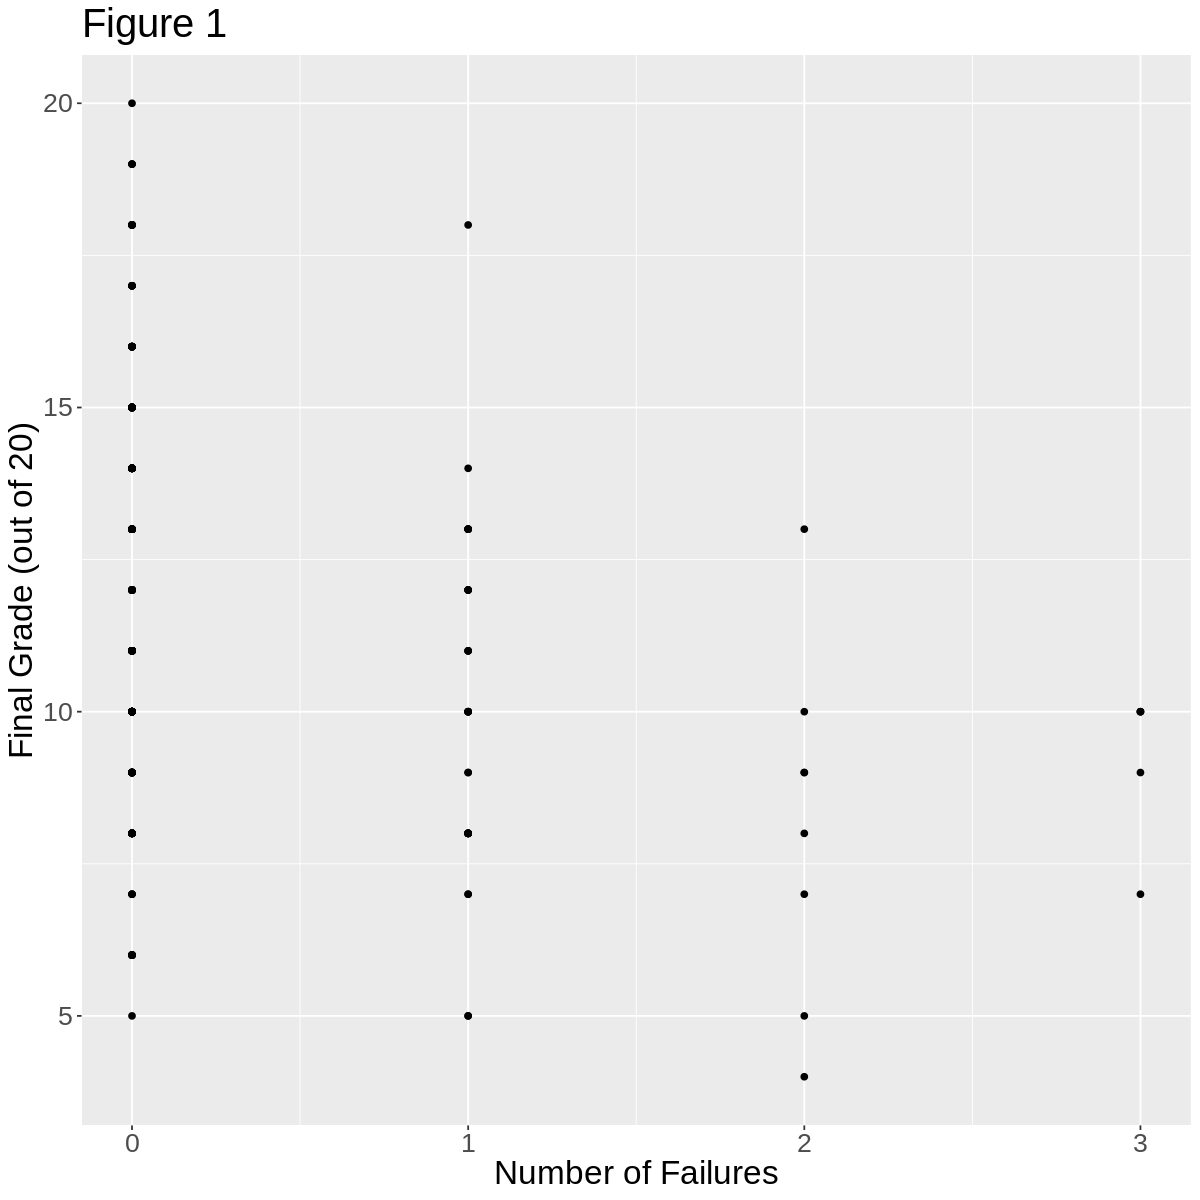

In [36]:
# Exploratory plot of Final Grade vs Number of Failures
student_plot <- ggplot(student_train, aes(x = failures, y = G3)) +
    geom_point() +
    labs(x = "Number of Failures" , y = "Final Grade (out of 20)") +
    ggtitle("Figure 1") +
    theme(text = element_text(size = 20))
student_plot

From the above graph, due to the nature of the data itself, it is difficult to gleam any useful information. But we can see that those that achieve a high final grade would tend to have a fewer number of failures. We are also unable to tell the number of each people at each point from this graph.

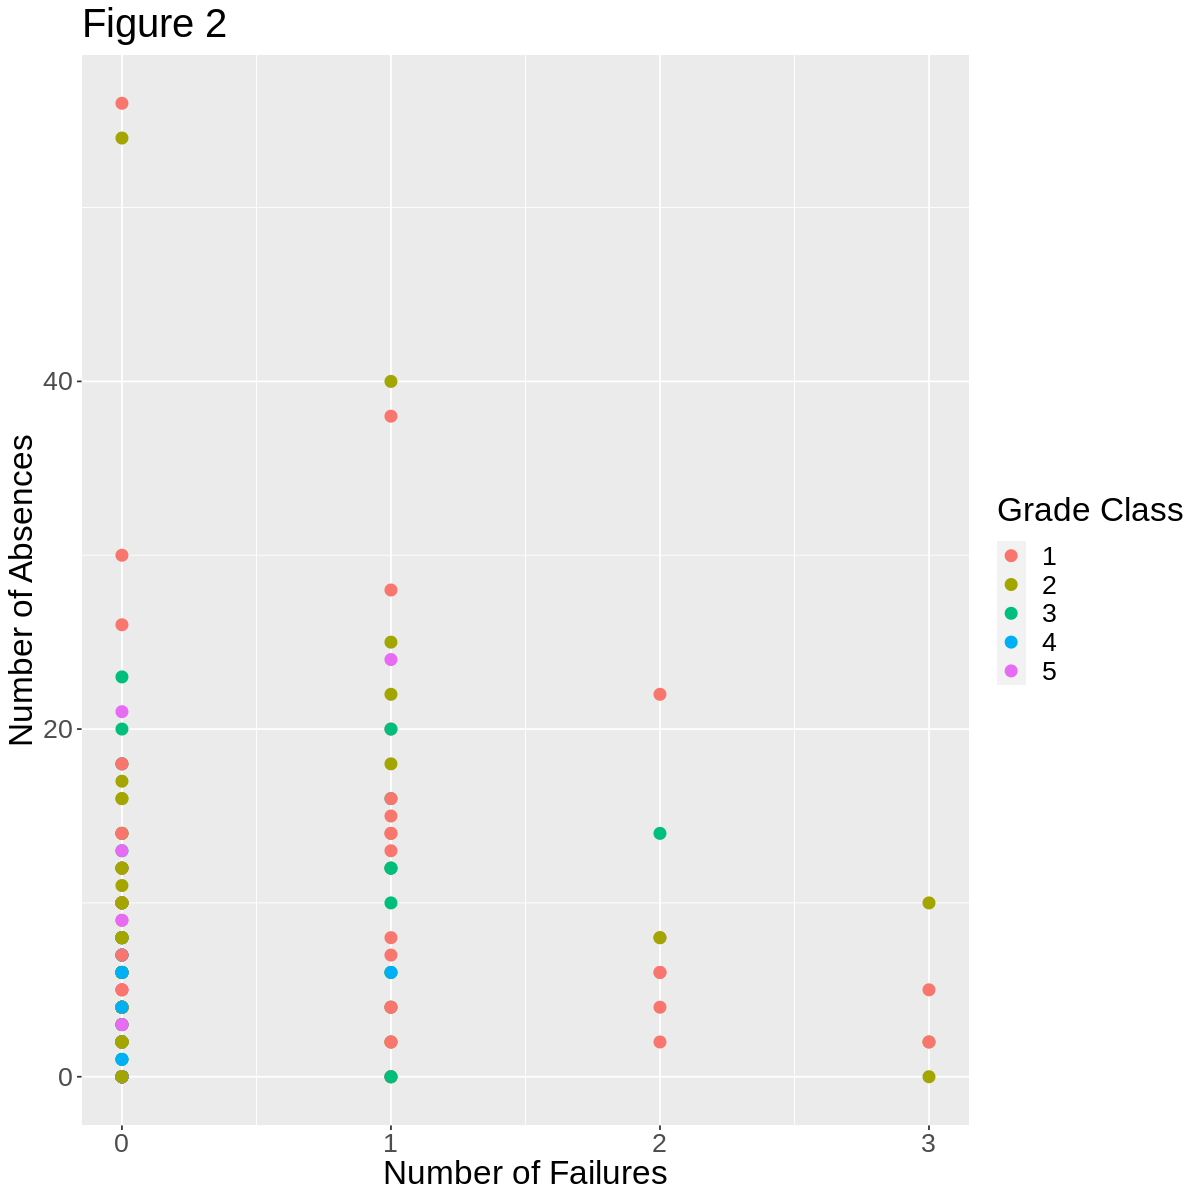

In [37]:
# Exporatory plot of Number of Absences vs Number of Failure with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = failures, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Number of Failures" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    ggtitle("Figure 2") +
    theme(text = element_text(size = 20))
student_plot2

On this graph, the details are a bit more clear. One might expect a different distribution of data points on this graph, where the data points are more towards the top right of the graph meaning that those with a high number of class absences would also fail more classes. An important note here is that students who score a high grade in class both have low number of failures (0-1) and low number of absences (<20).

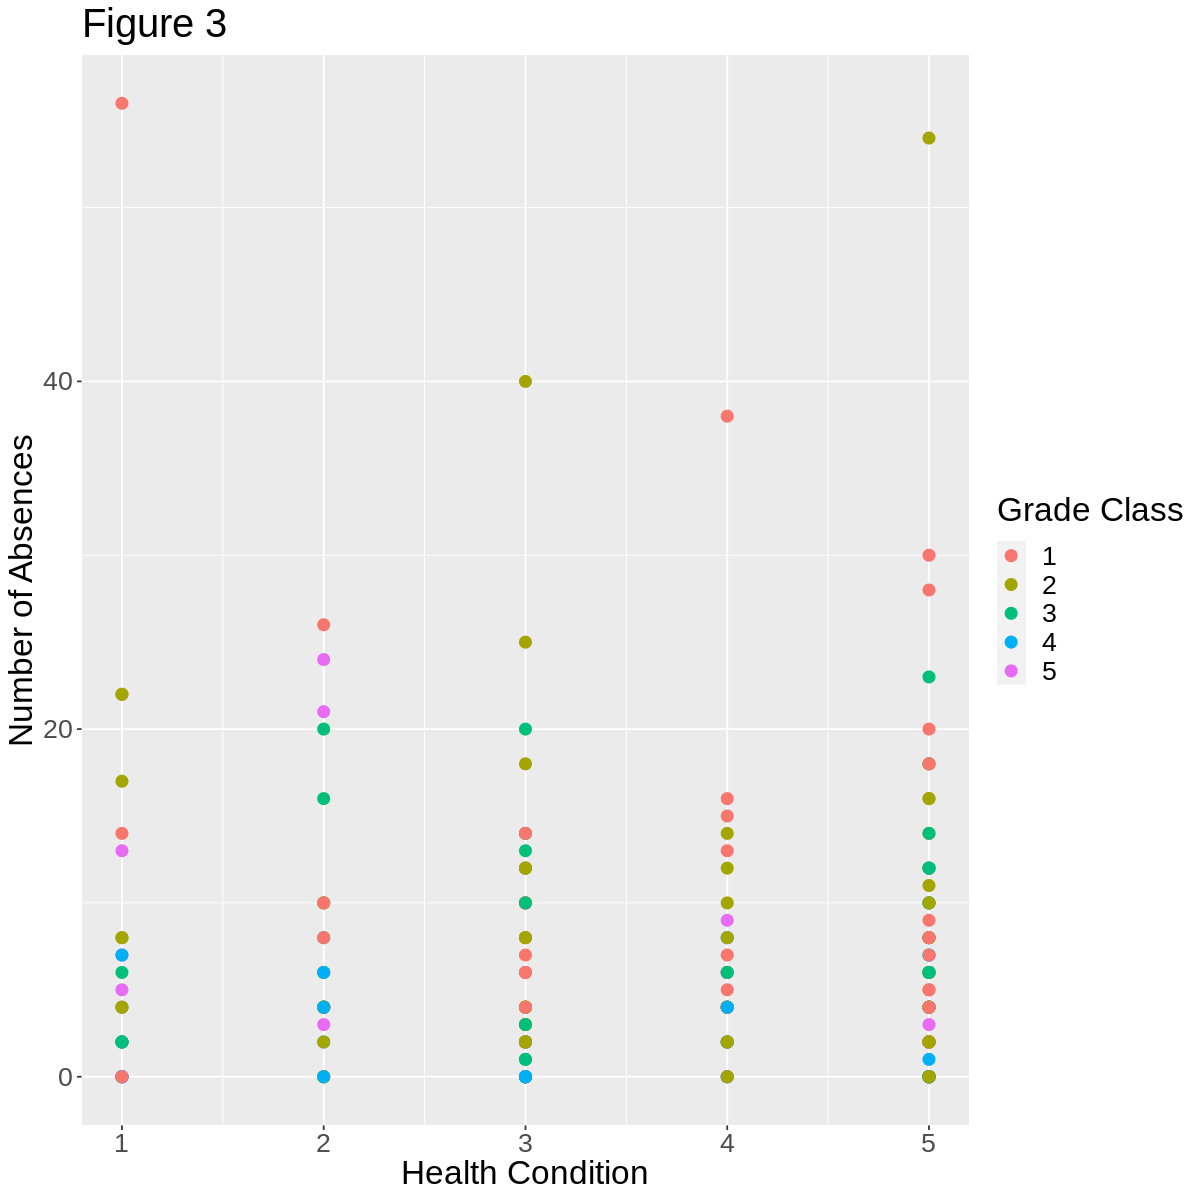

In [38]:
# Exporatory plot of Number of Absences vs Health with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = health, y = absences, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Health Condition" , y = "Number of Absences", fill = "Grade Class", color = "Grade Class") +
    ggtitle("Figure 3") +
    theme(text = element_text(size = 20))
student_plot2

From this graph, we can see that students with high grades will have low number of absences regardless of their health condition, while having a low number of absences. At the same time, students, regardless of their health condition, will have a low grade if they have a higher number of absences.

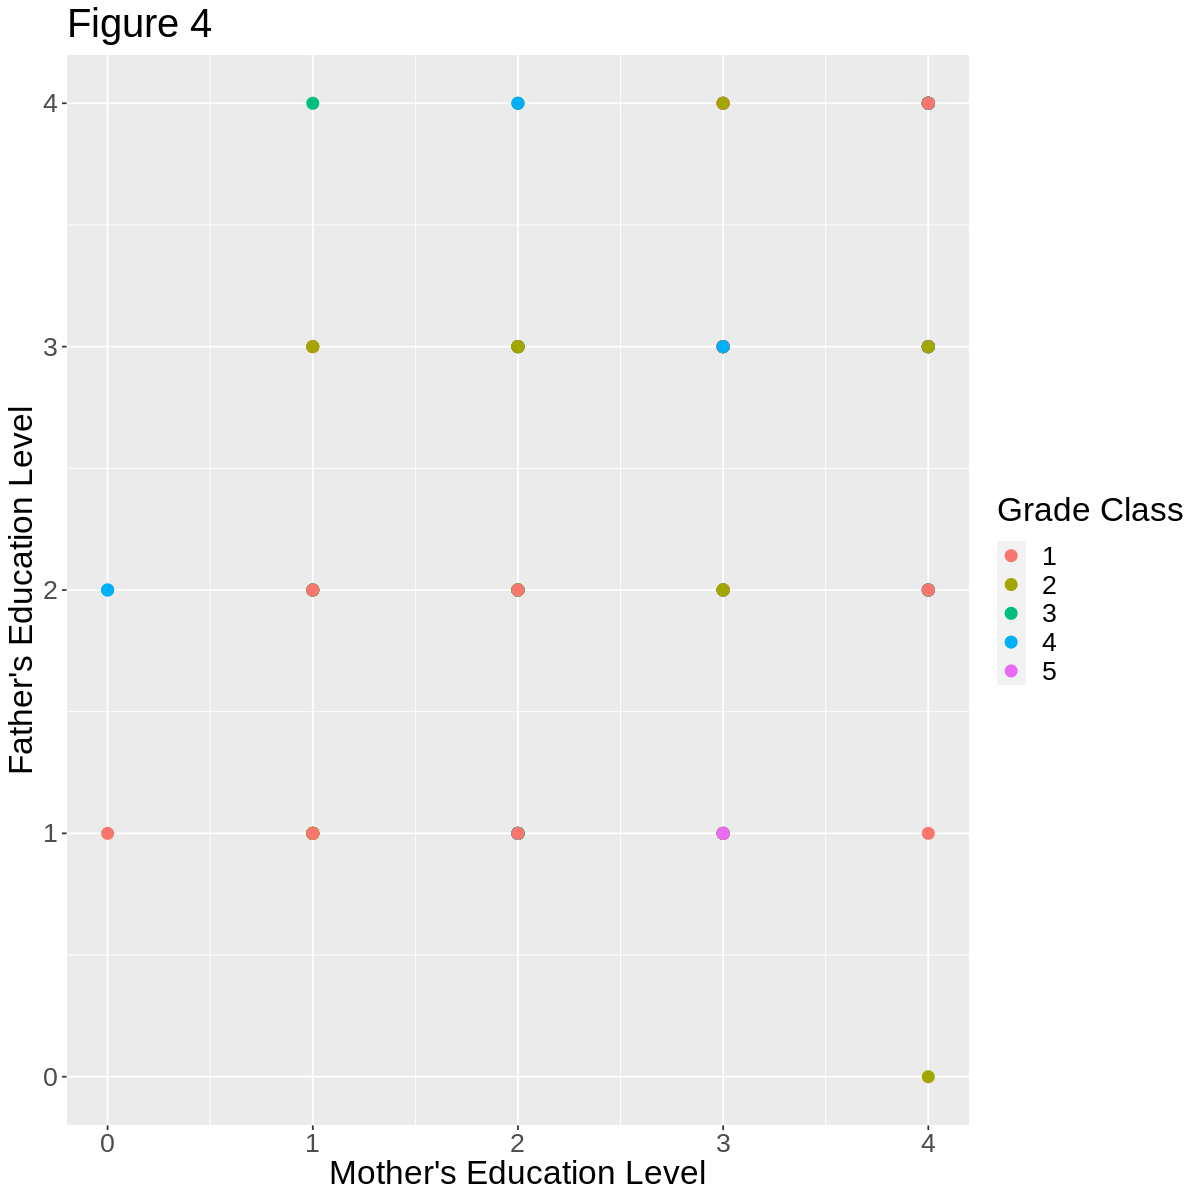

In [39]:
# REMOVE
# Exporatory plot of Mother's vs Father's Education Level with Grades as class labels
student_plot2 <- ggplot(student_train, aes(x = Medu, y = Fedu, fill = label)) +
    geom_point(aes(color = label), size = 3) +
    labs(x = "Mother's Education Level" , y = "Father's Education Level", fill = "Grade Class", color = "Grade Class") +
    ggtitle("Figure 4") +
    theme(text = element_text(size = 20))
student_plot2

Of the remaining factors that were left, we decided to use only number of failures and number of absences as predictors of the student's final grade. In the preliminary data analysis, these two were the only two variables turned out to be of a significant role when predicting the final grades. Term 1 and 2 grades did also work well in predicting a student's final grade, however our analysis does not use them because using grades to predict later grades does not necessarily answer the question of what factors or behaviors affect academic performance.

In [40]:
# model specification to produce a baseline accuracy
set.seed(2020)

#failures + absences
student_recipe <- recipe(label ~ failures + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit <- workflow() %>%
     add_recipe(student_recipe) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6728625
Best kernel: rectangular
Best k: 5

In [41]:
#
student_test_pred <- predict(knn_fit, student_test) %>%
    bind_cols(student_test)

accuracy = student_test_pred %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.22727273
kap,multiclass,0.02620016


          Truth
Prediction 1 2 3 4 5
         1 8 3 3 3 1
         2 8 7 1 3 2
         3 1 3 1 1 0
         4 3 9 7 3 6
         5 3 3 3 5 1

With 5 neighbours we found that the accuracy is only 26% and we can definitely do better. We will tune our classifier in order to increase our accuracy.

In [42]:
# cross-validation
student_vfold <- vfold_cv(student_train, v = 5, strata = label)

set.seed(2020)

student_recipe_2 <- recipe(label ~ failures + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2 <- workflow() %>%
    add_recipe(student_recipe_2) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2 %>% collect_metrics()

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2335789,5,0.017828462
roc_auc,hand_till,0.5071686,5,0.009379663


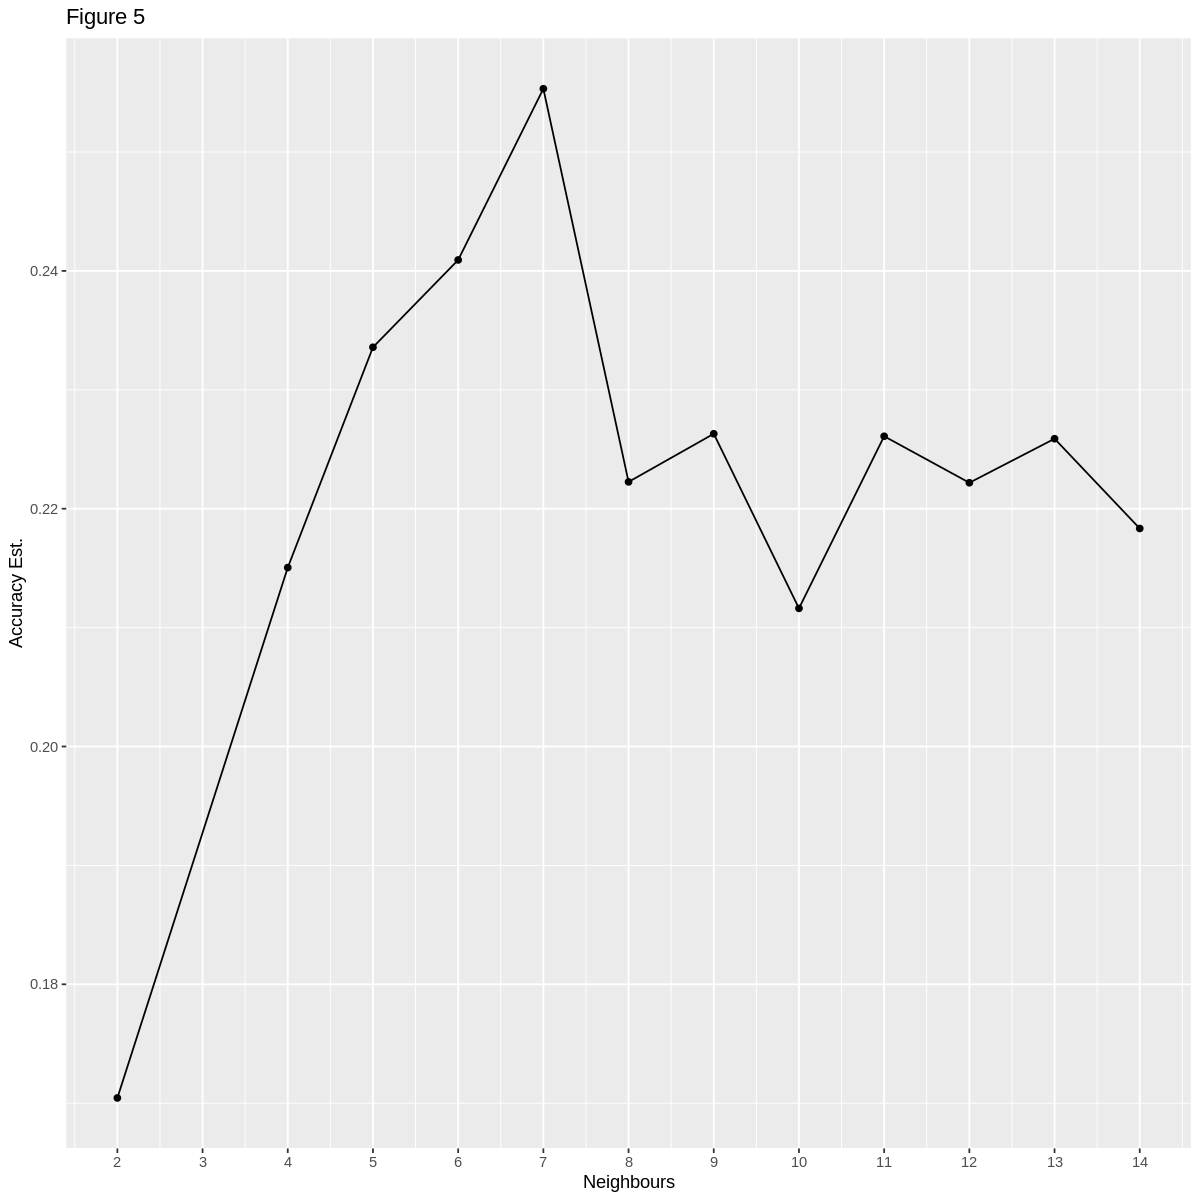

In [43]:
# Finding the best K by plotting accuracy vs K

knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

set.seed(2020)

knn_results_tuned <- workflow() %>%
    add_recipe(student_recipe) %>%
    add_model(knn_spec_tune) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()


accuracies <- knn_results_tuned %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Est.") +
    ggtitle("Figure 5") +
    scale_x_continuous(breaks = 1:15)
    
accuracy_vs_k

Figure 5 suggests that $K$ =  7 provides the highest accuracy. Unfortunately, the accuracy is only slightly above our previous $K$ of 5. With $K$ = 7, the accuracy increases to just over 30%, while at $K$ = 5, the accuracy was 26%.

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.7286245
Best kernel: rectangular
Best k: 5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.28409091
kap,multiclass,0.06081653


          Truth
Prediction  1  2  3  4  5
         1  4  5  1  5  2
         2 13 13  6  4  5
         3  3  4  4  3  1
         4  2  2  2  3  1
         5  1  1  2  0  1

.metric,.estimator,mean,n,std_err
<chr>,<chr>,<dbl>,<int>,<dbl>
accuracy,multiclass,0.2597092,5,0.01974266
roc_auc,hand_till,0.5461850,5,0.01097703


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.2193698,5,0.02334141,Model01
2,accuracy,multiclass,0.2120298,5,0.02573548,Model02
3,accuracy,multiclass,0.2229363,5,0.02458862,Model03
4,accuracy,multiclass,0.2598490,5,0.02325012,Model04
6,accuracy,multiclass,0.2673989,5,0.01633779,Model05
7,accuracy,multiclass,0.2671244,5,0.01507770,Model06
8,accuracy,multiclass,0.2487380,5,0.01073896,Model07
9,accuracy,multiclass,0.2675467,5,0.01650319,Model08
10,accuracy,multiclass,0.2749619,5,0.01275440,Model09


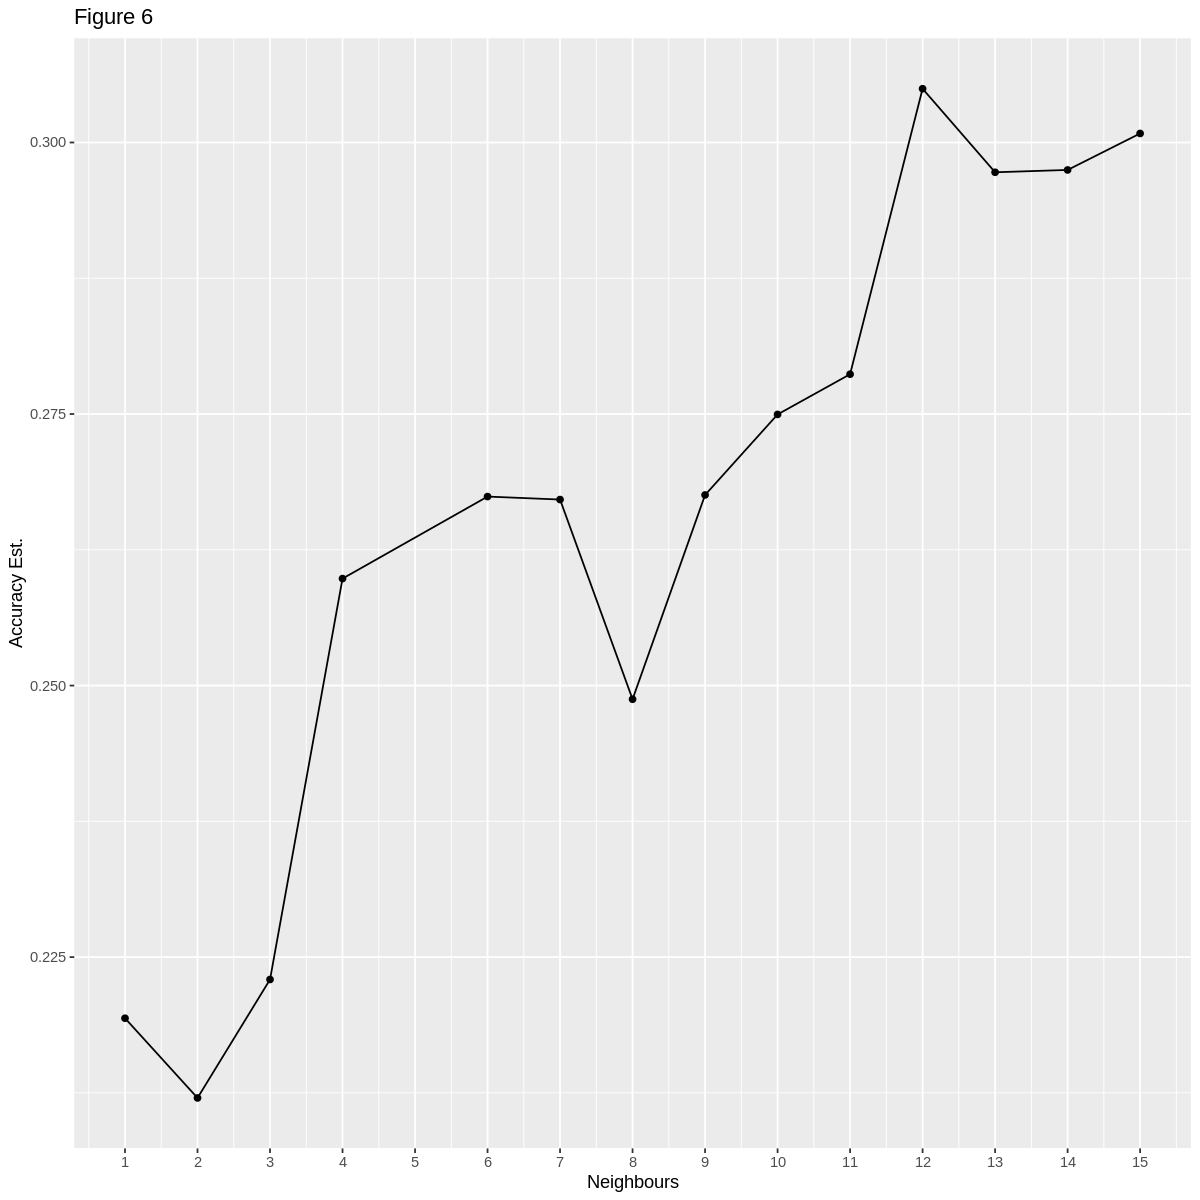

In [46]:
#### TEST

set.seed(2020)
# Medu + Fedu + studytime + failures + famrel + health + absences
student_recipe_time <- recipe(label ~ traveltime + goout + studytime + freetime + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())
    
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
     set_engine("kknn") %>%
     set_mode("classification")


knn_fit_time <- workflow() %>%
     add_recipe(student_recipe_time) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

knn_fit_time

student_test_pred_time <- predict(knn_fit_time, student_test) %>%
    bind_cols(student_test)

accuracy = student_test_pred_time %>%
    metrics(truth = label, estimate = .pred_class)

confusion = student_test_pred %>%
    conf_mat(truth = label, estimate = .pred_class)

accuracy
confusion

student_vfold <- vfold_cv(student_train, v = 5, strata = label)


student_recipe_2_time <- recipe(label ~ traveltime + goout + studytime + freetime + health + absences, 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

knn_fit_2_time <- workflow() %>%
    add_recipe(student_recipe_2_time) %>%
    add_model(knn_spec) %>%
    fit_resamples(resamples = student_vfold)

knn_fit_2_time %>% collect_metrics()

knn_spec_tune_time <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")


knn_results_tuned_time <- workflow() %>%
    add_recipe(student_recipe_time) %>%
    add_model(knn_spec_tune_time) %>%
    tune_grid(resamples = student_vfold, grid = 15) %>%
    collect_metrics()

accuracies <- knn_results_tuned_time %>%
    filter(.metric == "accuracy")

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Est.") +
    ggtitle("Figure 6") +
    scale_x_continuous(breaks = 1:15)
    
accuracies
accuracy_vs_k

As we were concerned about the low accuracy, here we test our accuracy if we use more variables. The code above follows the eaxact same steps as the code analyzing only number of failures and abscences, but here looks at travel time, time spent out with friends, study time, free time, health, and absences. These variables were chosen around a main idea of how time spent would affect academic performance. Figure 6 suggests that $K$ = 12 will produce the highest accuracy of 30%. This accuracy is not notably better than the accuracy produced from the data analysis of absences and failures, so we continue our analysis according to $K$ from our previous predictors.

In [47]:
# Now we'll perform KNN on our test data with K = 6

#creating our final KNN model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 6) %>%
    set_engine("kknn") %>%
    set_mode("classification")

# centering/scaling recipe
student_recipe <- recipe(label ~ traveltime + goout + studytime + freetime + health + absences , 
                         data = student_train) %>%
     step_scale(all_predictors()) %>%
     step_center(all_predictors())

# making our workflow
knn_fit <- workflow() %>%
     add_recipe(student_recipe_time) %>%
     add_model(knn_spec) %>%
     fit(data = student_train)

# predicting labels on test set
student_test_preds <- predict(knn_fit, student_test) %>%
    bind_cols(student_test)

head(student_test_preds)


.pred_class,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,label
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2,3,3,1,2,0,4,3,2,1,2,5,4,6,10,10,2
4,4,4,2,2,0,4,1,4,1,1,1,6,6,5,6,1
3,3,2,1,1,3,5,5,5,2,4,5,16,6,5,5,1
2,2,2,1,1,2,1,2,2,1,3,5,14,6,9,8,1
4,3,3,1,1,0,5,3,4,4,4,1,6,10,13,13,3
1,2,1,1,2,0,5,3,4,1,1,2,8,8,9,10,2


In [48]:
# computing the accuracy of our model

student_test_preds %>%
    metrics(truth = label, estimate = .pred_class)

# confusion matrix

student_test_preds %>%
    conf_mat(truth = label, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.28409091
kap,multiclass,0.06017969


          Truth
Prediction  1  2  3  4  5
         1  4  6  1  7  2
         2 13 12  7  1  5
         3  4  4  4  3  1
         4  2  2  2  4  1
         5  0  1  1  0  1

Using our KNN model with K = 6, we were able to predict a student's final grade with an accuracy of 35%.

**Discussion**

summarize what you found

discuss whether this is what you expected to find?

discuss what impact could such findings have?

discuss what future questions could this lead to?

Our research question asks how certain academic predictors affect the final math grade of a university student. We expected to find a correlation between a student’s past abscences and failures and their final grade. Students with records of more effort were expected to continue those trends. 

The highest accuracy our model was able to achieve is 35% after testing various predictors and $K$s. The low accuracy may be credited to the data set's choice of predictors. The study includes predictors such as travel time, study time, which have been shown to have a negible effect on grades (Wu 2014, Plant et al. 2005). However, it also includes health and social factors such as extraversion, which have been shown to have a complex - but large - effect on academic performance (Ding et al. 2009, Pritchard and Wilson 2003). These factors were all graded on the same 1-5 scale, which does not allow space to consider their nuance. The issue of our low accuracy could be ascribed to the researchers choice of variables, which are not neccesarily appropraite for predicting grades, and if they are, may not be presented in a way that accurately includes the details of what is affecting academic performance.

If used correctly, predicting which students are at risk of poor academic performance could be used to offer extra support, either individually or through the academic infastructre. However, the methods to determine an student at risk of failure may be difficult to perfect. Factors that you may have assumed were relevant, such as study time, could have little to no documented effect. Factors with a large effect, such as health and stress, are so varied and closely connected to such a massive quantity of other factors that it may be difficult to condense their complexities into a data set.

**References**

Cortez, P. and A. Silva. "Using Data Mining to Predict Secondary School Student Performance." In A. Brito and J. Teixeira Eds., Proceedings of 5th FUture BUsiness TEChnology Conference (FUBUTEC 2008) pp. 5-12, Porto, Portugal, April, 2008, EUROSIS, ISBN 978-9077381-39-7.

Ding, Weili, et al. "The impact of poor health on academic performance: New evidence using genetic markers." _Journal of Health Economics_
vol. 28, no. 3, May 2009, pp. 578-597. _Science Direct_, https://doi.org/10.1016/j.jhealeco.2008.11.006.

Plant, E. Ashby, et al. "Why study time does not predict grade point average across college students: Implications of deliberate practice for academic performance."_Contemporary Educational Psychology_, vol. 30, no. 1, 2005, pp. 96-116. _Science Direct_, https://doi.org/10.1016/j.cedpsych.2004.06.001.

Pritchard, Mary E and Gregory S. Wilson. "Using Emotional and Social Factors to Predict Student Success." _Journal of College Student Development_, vol. 44, no. 1, January 2003, pp. 18-28.

Wu, Qianying. "Associations Between Travel Behavior and the
Academic Performance of University Students." _All Theses_, 2014. https://tigerprints.clemson.edu/all_theses/2063.